## Assignment 1
# Group 13
Mathieu Mailhot - Isabel Lougheed - Frank-Lucas Pantazis

Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [ ]:
"""
- CKD: 28 numerical features, 1 target binary classification variable ("Normal" / "battery")
- Battery: 32 real-valued features, 2 classes ("Normal" / "Defective")
"""

# load data sets

# Calculate cross entropy or/ Information Gain for all the data without the threshold

# statistical analysis on the datasets

# - normalize

# models: all features, selective features based on statistical analysis (dropping features)


Statistics

In [ ]:
# load data sets
df_CKD = pd.read_csv("CKD.csv")
df_battery = pd.read_csv("Battery_Dataset.csv")

# Convert "CKD" to 1 and "Normal" to 0
df_CKD["label"] = df_CKD["label"].replace({"CKD": 1, "Normal": 0})
# Convert "Defective" to 1 and "Normal" to 0
df_battery["label"] = df_battery["label"].replace({"Defective": 1, "Normal": 0})

# Convert to a numpy array
CKD_data = df_CKD.to_numpy()
battery_data = df_battery.to_numpy()

In [ ]:
# Statistical Analysis Block

# Class for the analysis
class Stat_analysis:
    def __init__(self, data, name, save_folder):
        self.data = data
        self.name = name
        self.save_folder = save_folder
        self.feature_distribution()
        self.class_distrubution()

    # Function to create a distribution for each feature
    def feature_distribution(self):
        for i in range(self.data.shape[1] - 2): # remove 1 and last column as we do not need them for the distribution of the features
            feature_num = i + 1

            plt.hist(self.data[:,feature_num], bins=20, edgecolor="black")
            plt.xlabel("Value")
            plt.ylabel("Frequency")
            plt.title(f"{self.name} Distribution of Feature {feature_num}")

            filename = os.path.join(self.save_folder, f"{self.name}_feature{feature_num}_distribution.png")
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            plt.close()
    
    # Function to create a distribution for the class
    def class_distrubution(self):
        my_bins = [-0.5, 0.5, 1.5]
        class_0 = "Normal"
        if self.name == "CKD":
            class_1 = "CKD"
        else:
            class_1 = "Defective"

        plt.hist(self.data[:,self.data.shape[1] - 1], bins=my_bins, edgecolor="black", align="mid", rwidth=0.6)
        plt.xticks([0, 1], [class_0, class_1])
        plt.xlabel("Category")
        plt.ylabel("Frequency")
        plt.title(f"{self.name} Distribution of Class")

        filename = os.path.join(self.save_folder, f"{self.name}_class_distribution.png")
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.close()

# Perform the stastical analysis
CKD_stat = Stat_analysis(CKD_data, "CKD", "CKD_distribution")
battery_stat = Stat_analysis(battery_data, "Battery", "Battery_distribution")




In [ ]:
class Model:
    def __init__(self,  dataframe, data_array, description:str = None):
        
        # Hyperparameter variables for Adam Gradient Descent Algorithm
        self.max_iteration = 2000
        self.tolerance = 10**-6 #3
        self.step_size = 0.03
        self.b_1 = 0.95
        
        # Data variables
        self.dataframe = dataframe
        self.data_array = data_array
        self.description = description
        
        # Training and Validation variables
        self.accuracy_arr = []
        self.avg_accuracy = 0
        
        self.weigth_arr = []
        self.avg_weigth = 0

        self.avg_loss_per_iteration = []
        self.figure = []
    
    def normalize(self, normalize_by_max:bool, standardize:bool): 
        # Normalize the dataset
        # I think you should only normalize by max OR standardize, and I think standardizing would produce better results

        # Separate features and target
        df = self.dataframe # make sure data is a data frame
        features = df.drop(['ID', 'label'], axis=1)
        target = df['label']

        df_norm = df # if normalize_by_max = false and standardize = false, will return original df

        if normalize_by_max:
            # normalizing by extremas, scales to [0,1]
            # ensures data is well-conditioned
            features_normalized = (features - features.min())/(features.max() - features.min())
            df_norm = pd.concat([df[['ID']], features_normalized, df[['label']]], axis=1)

        if standardize:
            # z score normalization, good for gaussian distributions
            # forces std 1 and mean 0
            features_standardized = (features - features.mean())/features.std()
            df_norm = pd.concat([df[['ID']], features_standardized, df[['label']]], axis=1)

        # returns a pandas dataframe
        return df_norm
    
    def crossValidation(self, folds:int,learning_rate = None, tolerance = None, beta = None): 
        # Split dataset into folds
        # I think that self.data should only include non test data

        # hyperparameters Change
        if (learning_rate):
            self.step_size = learning_rate
        if (tolerance):
            self.tolerance = tolerance
        if (beta):
            self.b_1 = beta

        data = self.data_array[:,1:] # removing first column (ID)
        fold_size = len(data) // folds
        validation_experiments = []
        train_experiments = []

        

        for i in range(folds):
            if i==(folds-1):
                # how should i deal with uneven split ??? is it okay for the last fold to be smaller?
                validation_fold = data[(i*fold_size):]  #df.iloc[(i*fold_size):(len(df))]
                train_fold = data[:(i*fold_size)] #pd.concat([df.iloc[:(i*fold_size)], df.iloc[(len(df)):]])

            else:
                validation_fold = data[(i*fold_size):(i*fold_size + fold_size)] #df.iloc[(i*fold_size):(i*fold_size + fold_size)]
                train_fold = np.vstack([data[:(i*fold_size)], data[(i*fold_size + fold_size):]]) #pd.concat([df.iloc[:(i*fold_size)], df.iloc[(i*fold_size + fold_size):]])
            validation_experiments.append(validation_fold)
            train_experiments.append(train_fold)

        # Train
        avg_error1 = 0
        avg_error2 = 0
        
        for i in range(folds):
            # train each training set with fit() to get weights
            train_experiment = train_experiments[i]
            w = self.fit(train_experiment)
            self.weigth_arr.append(w.tolist())
            # get errors 
            validation_experiment = validation_experiments[i]
            error1,error2 = self.Accu_eval(w, validation_experiment) 
            
            avg_error1 += error1
            avg_error2 += error2
        
        self.avg_weigth = np.mean(np.array(self.weigth_arr),axis = 0)
        

        avg_error1 = avg_error1/folds
        avg_error2 = avg_error2/folds
        
        #print("MSE error:", avg_error1)
        #print("Accuracy error:", avg_error2)
        for pos in range(len(self.avg_loss_per_iteration)):
            num = self.avg_loss_per_iteration[pos][0]
            item = self.avg_loss_per_iteration[pos][1]
            self.figure.append(item/num)
        
        return (avg_error1,avg_error2)

    def fit(self,train_data):
        
        # Trains using gradient descent: Lecture 5 slide 55-58

        w_prev = np.ones(train_data.shape[1])*1 # (number of columns of train_data - 1 to remove label, + 1 to account for bias term)
        m = 0
        correct_prediction = 0

        for epoch in range(self.max_iteration):
            delta = np.zeros(len(w_prev))
            correct_prediction = 0
            for row_i in train_data:
                y_i = row_i[-1] # extracting value
                x_i = row_i.copy() # extracting features
                x_i[-1] = 1 # because of bias term
                delta += x_i*(y_i-self.predict(w_prev,x_i))
                if (y_i-self.predict(w_prev,x_i)<=0.5):
                    correct_prediction+=1
        

            #m = self.b_1 * m + (1-self.b_1) * delta
            w_new = w_prev + self.step_size/(1+epoch) * delta
            #w_new = w_prev + self.step_size * m  # to be able to reach better precision need to devide step size by num iteration
       
            w_diff = np.linalg.norm(w_new - w_prev)
            
            w_prev = w_new
            if (len(self.avg_loss_per_iteration)<=epoch):
                self.avg_loss_per_iteration.append([1,1-correct_prediction/len(train_data)])
               
            else:
                self.avg_loss_per_iteration[epoch][0] +=1 
                self.avg_loss_per_iteration[epoch][1]+= 1-correct_prediction/len(train_data)
            if (w_diff**2<self.tolerance):
                return w_new
            
       
        
        # Means there was a problem
        print("Not converged", w_new , w_diff)
        return w_new

    
    def predict(self,w,x):
        # Predicts output: function at bottom Lecture 5 slide 44
        a = w.T @ x
        return 1/(1+np.exp(-np.clip(a, -500, 500)))

    def Accu_eval(self,w,validate_data): # Used MSE
        # Validation
        error = 0
        correct_prediction = 0
        for row_i in validate_data:
            y_i = row_i[-1] # extracting value
            x_i = row_i.copy() # extracting features
            x_i[-1] = 1
            
            error += (y_i-self.predict(w,x_i))**2 
            if ((y_i-self.predict(w,x_i))<=0.5):
                correct_prediction+=1
        
        return (error/len(validate_data), 1-correct_prediction/len(validate_data))

    def hyperparameterAnalysis(self,folds):
        if (False):

            i = 0
            for a in np.arange(0.001,0.011,0.001):
                self.clear()
                plt.figure(i)
                for b in np.arange(0.9,1,0.01):
                    
                    self.clear()   
                    self.crossValidation(folds,learning_rate=a,beta=b)
                    self.addPlot(f"beta = {round(b,3)}")
                plt.title(f'Analysis of beta when alpha = {round(a,4)}') 
                plt.xlabel('Iterations')
                plt.ylabel('Accuracy')
                plt.grid(True)
                plt.legend()
                plt.show() 
                i+=1
        else:
            plt.figure(1)
            i=1
            for a in np.arange(0.01,0.11,0.01):
                self.clear()
                print(f"plot {i}")
                i+=1
                self.crossValidation(folds,learning_rate=a)
                self.addPlot(f"alpha = {round(a,3)}")
                
            plt.title(f'Analysis of alpha') 
            plt.xlabel('Iterations')
            plt.ylabel('1-Accuracy')
            plt.grid(True)
            plt.legend()
            plt.show() 

            
        
        

    def addPlot(self,legend_label):
        x = np.array(range(len(self.avg_loss_per_iteration)))
        y = self.figure
        plt.plot(x, y, label=legend_label)
    
    def clear(self):
        self.accuracy_arr = []
        self.avg_accuracy = 0
        self.figure =[]
        self.weigth_arr = []
        self.avg_weigth = 0

        self.avg_loss_per_iteration = []

class Analysis:
     def __init__(self, model, descriptor):
         print(descriptor)

         df_norm = model.normalize(True,False)
         df_norm.drop(['ID', 'label'], axis=1)
         norm_model = Model(df_norm, df_norm.to_numpy(),"\tNormalised")

         df_stand = model.normalize(False, True)
         df_stand.drop(['ID', 'label'], axis=1)
         stand_model = Model(df_norm, df_norm.to_numpy(),"\tStandardized")

         norm_model.crossValidation(10)
         stand_model.crossValidation(10)
         
     """     for b in np.arange(0.9,1,0.01):
            self.clear()
            self.crossValidation(folds,beta=b)
            self.addPlot(f"beta = {round(b,2)}")
        plt.title('Analysis of beta')    
        plt.xlabel('Iterations')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        plt.show()"""
            

In [684]:
# Partition data into training and testing

# Shuffle data
df_CKD = df_CKD.sample(frac = 1, random_state = 2).reset_index(drop=True)
df_battery = df_battery.sample(frac = 1, random_state = 2).reset_index(drop=True)

# Taking approximately 90% of data for training and validation
non_testing_size_ckd = 10*(int(0.9*len(df_CKD))//10) # make size of training/validation set dividible for 10 so it is suitable for a 10 fold cross validation
train_df_CKD = df_CKD.iloc[:non_testing_size_ckd]
train_CKD_data = train_df_CKD.to_numpy()

non_testing_size_battery = 10*(int(0.9*len(df_battery))//10) # make size of training/validation set dividible for 10 so it is suitable for a 10 fold cross validation
train_df_battery = df_battery.iloc[:non_testing_size_battery]
train_battery_data = train_df_battery.to_numpy()

# Taking 10% of data for testing
test_df_CKD = df_CKD.iloc[non_testing_size_ckd:]
test_battery_CKD = test_df_CKD.to_numpy()

test_df_battery = df_battery.iloc[non_testing_size_battery:]
test_battery_data = test_df_battery.to_numpy()

In [709]:
# testing whole model for CKD data with cross validation


ckd_model = Model(df_CKD, CKD_data, "This is the model for the CKD dataset")
features_ckd = df_CKD.drop(['ID', 'label'], axis=1)

def condition_number(features):
    A = features.to_numpy()
    U, S, V = np.linalg.svd(A, full_matrices=False)
    condition_num = np.max(S) / np.min(S[np.nonzero(S)])
    return condition_num

# normalize data
df_norm = ckd_model.normalize(True, False)
features_ckd_norm = df_norm.drop(['ID', 'label'], axis=1)
ckd_model_norm = Model(df_norm, df_norm.to_numpy())

# standardize data
df_stand = ckd_model.normalize(False, True)
features_ckd_stand = df_stand.drop(['ID', 'label'], axis=1)
ckd_model_stand = Model(df_stand, df_stand.to_numpy())

#print("Condition number of original dataset : ", condition_number(features_ckd))
print("Condition number of normalized dataset : ", condition_number(features_ckd_norm))
print("Condition number of standardized dataset : ", condition_number(features_ckd_stand))
print("---------------------------------------------------------")
#print("Error after training original dataset : ", ckd_model.crossValidation(10))
print("Error after training normalized dataset : ", ckd_model_norm.crossValidation(10), ckd_model_norm.weigth_arr)



print("Error after training standardized dataset : ", ckd_model_stand.crossValidation(10),ckd_model_stand.avg_weigth)


Condition number of normalized dataset :  16.27262719478566
Condition number of standardized dataset :  1.681626037734023
---------------------------------------------------------
Error after training normalized dataset :  (0.20809266799343354, 0.16969696969696968) [[-0.796609383660904, 2.5085971357620696, -0.042428192736549936, -0.10042221357321506, -0.04369030011407315, 0.08478597093630452, -0.11885168943425502, -0.19048575530294953, -0.26953426269948855, -0.3082825371359306, 0.23993574763991887, 0.3790387815557187, 0.13119684335052917, 0.12923029937947478, -0.11458142109698331, -0.017838675068853848, 0.15070786144976234, 0.1528207283799823, 0.30719915511266715, -0.02822451930488266, 0.18287344953928406, -0.5668871726801139, -0.22351139194661693, 0.07530365036085267, 0.20122256268619643, -0.13541821402634624, -0.02492552040843641, 0.2273681728758303, -0.8213677060254686], [-0.8530143844985305, 2.5318528958627495, 0.04769110500629051, -0.09398002900017192, 0.11612800828059078, 0.10704

Condition number of normalized dataset :  17.6327958203812
Condition number of standardized dataset :  1.6891992219130865
---------------------------------------------------------
Error after training normalized dataset :  (0.08799190622918521, 0.06012785388127857) [ 5.63501121  5.38829973 -0.07781156  0.06696824 -0.13953089 -0.26569812
 -0.85147902 -0.64142941 -0.4188689  -0.08916607 -0.13668324 -0.35202057
 -0.06426685 -0.49696303 -0.4658426  -0.5416044  -0.16714815 -0.36761503
 -0.16330897 -0.22836593 -0.04230986  0.01516303  0.02860874  0.01601957
  0.0427523  -0.55813236  0.0472965  -0.56626923 -0.42278238 -0.27415862
 -0.30889331 -0.40980299 -1.67331983]
Error after training standardized dataset :  (0.0955263118117706, 0.0614977168949772) [ 4.65372908  4.76182454 -0.11524711  0.19752255 -0.12932468  0.24520765
 -0.53045458 -0.58289395  0.05296391  0.35129205  0.36870132 -0.49283307
  0.07576442 -0.06247612 -0.4800091  -0.26103647  0.10904603 -0.25896805
 -0.12593349 -0.09573121  

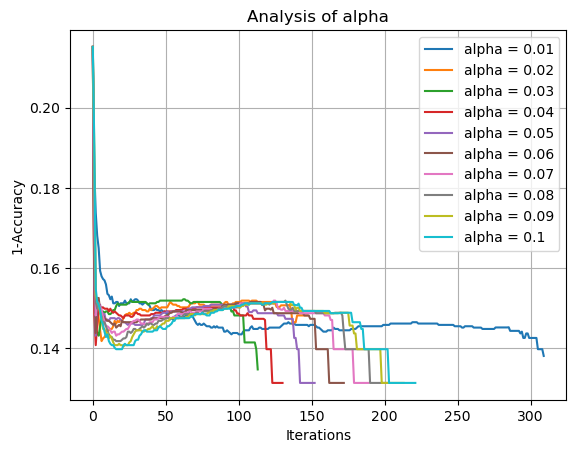

In [698]:
battery_model = Model(df_battery, battery_data, "This is the model for the battery dataset")
features_battery = df_battery.drop(['ID', 'label'], axis=1)

def condition_number(features):
    A = features.to_numpy()
    U, S, V = np.linalg.svd(A, full_matrices=False)
    condition_num = np.max(S) / np.min(S[np.nonzero(S)])
    return condition_num

# normalize data
df_norm = battery_model.normalize(True, False)
features_battery_norm = df_norm.drop(['ID', 'label'], axis=1)
battery_model_norm = Model(df_norm, df_norm.to_numpy())

# standardize data
df_stand = battery_model.normalize(False, True)
features_battery_stand = df_stand.drop(['ID', 'label'], axis=1)
battery_model_stand = Model(df_stand, df_stand.to_numpy())

#print("Condition number of original dataset : ", condition_number(features_battery))
print("Condition number of normalized dataset : ", condition_number(features_battery_norm))
print("Condition number of standardized dataset : ", condition_number(features_battery_stand))
print("---------------------------------------------------------")
#print("Error after training original dataset : ", battery_model.crossValidation(10))
print("Error after training normalized dataset : ", battery_model_norm.crossValidation(10), battery_model_norm.avg_weigth)
#battery_model_norm.hyperparameterAnalysis(10)
print("Error after training standardized dataset : ", battery_model_stand.crossValidation(10),battery_model_stand.avg_weigth)
ckd_model_stand.hyperparameterAnalysis(10)

In [ ]:
# CKD Model 3: Linear model using only highest weighted features

# removing features
threshold_weight = 0.1
column_to_remove_ckd = []
for i in range(len(ckd_model_norm.weigth_arr)):
    if abs(ckd_model_norm.avg_weigth[i]) < threshold_weight:
        column_to_remove_ckd.append(i)
column_to_remove_visualize_ckd = [x + 1 for x in column_to_remove_ckd]
df_norm_CKD = ckd_model.normalize(True, False)
df_norm_CKD_removed_feature = df_norm_CKD.drop(df_norm_CKD.columns[column_to_remove_visualize_ckd], axis=1)

ckd_model_norm_removed_feature = Model(df_norm_CKD_removed_feature, df_norm_CKD_removed_feature.to_numpy())
print("---------------------------------------------------------")
print("Error after training normalized dataset with features removed: ", ckd_model_norm_removed_feature.crossValidation(10))
print(f"The features that are removed are : {column_to_remove_visualize_ckd}")
print("The weights of normalized dataset with features removed: ", ckd_model_norm_removed_feature.avg_weigth)
print(ckd_model_norm_removed_feature.avg_weigth.shape)
ckd_model_norm_removed_feature.hyperparameterAnalysis(10)

---------------------------------------------------------
Error after training normalized dataset with features removed:  (0.2039941972434141, 0.1727272727272727)
The features that are removed are : [3, 4, 5, 6]
The weights of normalized dataset with features removed:  [-0.86360759  2.53925127 -0.16242165 -0.25559325 -0.26086459 -0.10097133
  0.33800595  0.36966377  0.00569096  0.03502642 -0.16516508  0.11340091
  0.03548787  0.20407592  0.08879592  0.06484925  0.21854847 -0.46512494
 -0.26229379  0.04985734  0.04788599  0.011537   -0.01792996  0.2057306
 -0.81964566]
(25,)
plot 1
plot 2


In [ ]:
# Battery Model 3: Linear model using only highest weighted features

# removing features
threshold_weight = 0.05
column_to_remove_battery = []
for i in range(len(battery_model_norm.weigth_arr)):
    if abs(battery_model_norm.avg_weigth[i]) < threshold_weight:
        column_to_remove_battery.append(i)
column_to_remove_visualize_battery = [x + 1 for x in column_to_remove_battery]
df_norm_battery = battery_model_norm.normalize(True,False)
features_battery_norm_removed_columns = df_norm_battery.drop(df_norm_battery.columns[column_to_remove_battery], axis=1)
battery_model_norm_removed_feature = Model(features_battery_norm_removed_columns, features_battery_norm_removed_columns.to_numpy())
print("---------------------------------------------------------")
print("Error after training normalized dataset with features removed: ", battery_model_norm_removed_feature.crossValidation(10))
print(f"The features that are removed are : {column_to_remove_visualize_battery}")
print("The weights of normalized dataset with features removed: ", battery_model_norm_removed_feature.avg_weigth)
battery_model_norm_removed_feature.hyperparameterAnalysis(10)

AttributeError: 'Model' object has no attribute 'avg_weigth_arr'

In [ ]:
# CKD Model 4: Quadratic model using all features available, where highest weighted features have a quadratic term

# normalize data
ckd_model = Model(train_df_CKD, train_CKD_data, "CKD Model 1")
df_ckd_norm = ckd_model.normalize(True, False)
ckd_data_norm = df_ckd_norm.to_numpy()
ckd_model_norm = Model(df_ckd_norm, ckd_data_norm)

# get weights of linear model using all training data
train_data = ckd_data_norm[:,1:] # removing first column (ID)
weights = np.array(ckd_model_norm.fit(train_data))
print("Weights of linear model: ", weights)

num_quadratic_features = 2
top_weighted_features = np.argsort(np.abs(weights[:-1]))[-num_quadratic_features:] # taking top num_quadratic_features in magnitude of weights, excluding w_0 weight
print(f'The {num_quadratic_features} features with the highest magnitudes weights are ', top_weighted_features + np.ones(np.shape(top_weighted_features)))

# create new dataset
df_ckd_quadratic = train_df_CKD.copy()
data_ckd_quadratic = train_CKD_data.copy()

for i in top_weighted_features:
    df_ckd_quadratic[f'feature_{i}_squared'] = df_ckd_quadratic.iloc[:,i]**2 # adding a new quadratic feature to dataset

# normalize new quadratic dataset
ckd_model_quad = Model(df_ckd_quadratic, data_ckd_quadratic)
df_ckd_quad_norm = ckd_model_quad.normalize(True, False)
ckd_data_quad_norm = df_ckd_quad_norm.to_numpy()
ckd_model_quad_norm = Model(df_ckd_quad_norm, ckd_data_quad_norm, "CKD Model 4")

print(f"Error for model with {num_quadratic_features} quadratic features: ", ckd_model_quad_norm.crossValidation(10))
ckd_model_quad_norm.hyperparameterAnalysis(10)

In [689]:
# Battery Model 4: Quadratic model using all features available, where highest weighted features have a quadratic term

# normalize data
battery_model = Model(train_df_battery, train_battery_data, "Battery Model 1")
df_battery_norm = battery_model.normalize(True, False)
battery_data_norm = df_battery_norm.to_numpy()
battery_model_norm = Model(df_battery_norm, battery_data_norm)

# get weights of linear model using all training data
train_data = battery_data_norm[:,1:] # removing first column (ID)
weights = np.array(battery_model_norm.fit(train_data))
print("Weights of linear model: ", weights)

num_quadratic_features = 1
top_weighted_features = np.argsort(np.abs(weights[:-1]))[-num_quadratic_features:] # taking top num_quadratic_features in magnitude of weights, excluding w_0 weight
print(f'The {num_quadratic_features} features with the highest magnitudes weights are ', top_weighted_features + np.ones(np.shape(top_weighted_features)))

# create new dataset
df_battery_quadratic = train_df_battery.copy()
data_battery_quadratic = train_battery_data.copy()

for i in top_weighted_features:
    df_battery_quadratic[f'feature_{i}_squared'] = df_battery_quadratic.iloc[:,i]**2 # adding a new quadratic feature to dataset

# normalize new quadratic dataset
battery_model_quad = Model(df_battery_quadratic, data_battery_quadratic)
df_battery_quad_norm = battery_model_quad.normalize(True, False)
battery_data_quad_norm = df_battery_quad_norm.to_numpy()
battery_model_quad_norm = Model(df_battery_quad_norm, battery_data_quad_norm, "Battery Model 4")

print(f"Error for model with {num_quadratic_features} quadratic features: ", battery_model_quad_norm.crossValidation(10))
battery_model_quad_norm.hyperparameterAnalysis(10)

Weights of linear model:  [ 5.75770595  5.32042541 -0.36597877  0.1298155  -0.48009116 -0.17909957
 -0.88789417 -0.55023435 -0.1710874  -0.13552084 -0.0882606  -0.23785493
  0.02596821 -0.52288818 -0.53135034 -0.54850226 -0.11986168 -0.46641928
 -0.0450794  -0.20978599 -0.02431803  0.07276487 -0.04179155  0.0316412
  0.01128354 -0.45876124  0.02079946 -0.64431559 -0.45405818 -0.38985487
 -0.26232643 -0.24765017 -1.68339528]
The 1 features with the highest magnitudes weights are  [1.]
Error for model with 1 quadratic features:  (0.08773794485863369, 0.06153846153846151)


UnboundLocalError: local variable 'i' referenced before assignment

<Figure size 640x480 with 0 Axes>

Weights of linear model:  [-8.79306227e-01  2.49025381e+00 -2.03572578e-01 -8.76327396e-03
  1.87408418e-02  3.14190333e-01 -7.85323578e-02 -2.67218437e-01
 -2.36649673e-01 -1.51722863e-01  2.93381802e-01  2.41181111e-01
 -3.29889844e-02  1.07133151e-01 -2.29490022e-01  1.13791564e-01
 -1.51759667e-01  3.24234892e-01  8.32281681e-02  1.71707596e-01
  1.39912733e-01 -6.58444209e-01 -2.07301988e-01  9.00109760e-02
  8.63280294e-03  7.07046992e-02 -2.38003024e-03  3.12191928e-01
 -7.85701197e-01]
The 1 features with the highest magnitudes weights are  [2.]
Error for model with 1 cubic features:  (0.20807755291450594, 0.17931034482758623)
plot 1
plot 2
plot 3
plot 4
plot 5
plot 6
plot 7
plot 8
plot 9
plot 10


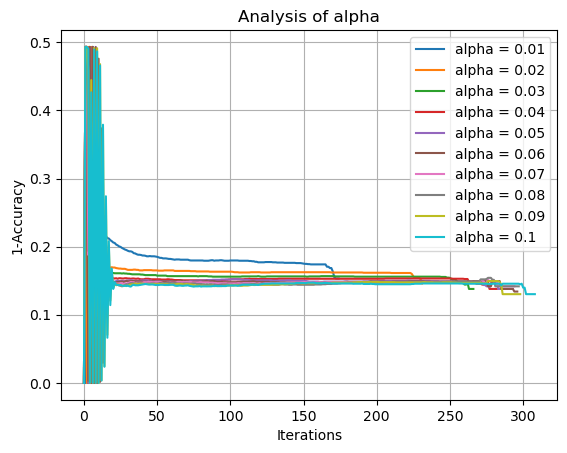

In [700]:
# CKD Model 5: Cubic model using all features available, where highest weighted features have a cubic term

# normalize data
ckd_model = Model(train_df_CKD, train_CKD_data, "CKD Model 1")
df_ckd_norm = ckd_model.normalize(True, False)
ckd_data_norm = df_ckd_norm.to_numpy()
ckd_model_norm = Model(df_ckd_norm, ckd_data_norm)

# get weights of linear model using all training data
train_data = ckd_data_norm[:,1:] # removing first column (ID)
weights = np.array(ckd_model_norm.fit(train_data))
print("Weights of linear model: ", weights)

num_cubic_features = 1
top_weighted_features = np.argsort(np.abs(weights[:-1]))[-num_cubic_features:] # taking top num_cubic_features in magnitude of weights, excluding w_0 weight
print(f'The {num_cubic_features} features with the highest magnitudes weights are ', top_weighted_features + np.ones(np.shape(top_weighted_features)))

# create new dataset
df_ckd_cubic = train_df_CKD.copy()
data_ckd_cubic = train_CKD_data.copy()

for i in top_weighted_features:
    df_ckd_cubic[f'feature_{i}_squared'] = df_ckd_cubic.iloc[:,i]**2 # adding a new quadratic feature to dataset
    df_ckd_cubic[f'feature_{i}_cubed'] = df_ckd_cubic.iloc[:,i]**3 # adding a new quadratic feature to dataset

# normalize new cubic dataset
ckd_model_cube = Model(df_ckd_cubic, data_ckd_cubic)
df_ckd_cube_norm = ckd_model_cube.normalize(True, False)
ckd_data_cube_norm = df_ckd_cube_norm.to_numpy()
ckd_model_cube_norm = Model(df_ckd_cube_norm, ckd_data_cube_norm, "CKD Model 5")

print(f"Error for model with {num_cubic_features} cubic features: ", ckd_model_cube_norm.crossValidation(10))

ckd_model_cube_norm.hyperparameterAnalysis(10)

In [708]:
# Battery Model 5: Cubic model using all features available, where highest weighted features have a cubic term

# normalize data
battery_model = Model(train_df_battery, train_battery_data, "Battery Model 1")
df_battery_norm = battery_model.normalize(True, False)
battery_data_norm = df_battery_norm.to_numpy()
battery_model_norm = Model(df_battery_norm, battery_data_norm)

# get weights of linear model using all training data
train_data = battery_data_norm[:,1:] # removing first column (ID)
weights = np.array(battery_model_norm.fit(train_data))
print("Weights of linear model: ", weights)

num_cubic_features = 1
top_weighted_features = np.argsort(np.abs(weights[:-1]))[-num_cubic_features:] # taking top num_cubic_features in magnitude of weights, excluding w_0 weight
print(f'The {num_cubic_features} features with the highest magnitudes weights are ', top_weighted_features + np.ones(np.shape(top_weighted_features)))

# create new dataset
df_battery_cubic = train_df_battery.copy()
data_battery_cubic = train_battery_data.copy()

for i in top_weighted_features:
    df_battery_cubic[f'feature_{i}_squared'] = df_battery_cubic.iloc[:,i]**2 # adding a new quadratic feature to dataset
    df_battery_cubic[f'feature_{i}_cubed'] = df_battery_cubic.iloc[:,i]**3 # adding a new quadratic feature to dataset

# normalize new cubic dataset
battery_model_cube = Model(df_battery_cubic, data_battery_cubic)
df_battery_cube_norm = battery_model_cube.normalize(True, False)
battery_data_cube_norm = df_battery_cube_norm.to_numpy()
battery_model_cube_norm = Model(df_battery_cube_norm, battery_data_cube_norm)

print(f"Error for model with {num_cubic_features} cubic features: ", battery_model_cube_norm.crossValidation(10))
battery_model_cube_norm.hyperparameterAnalysis(10)

Weights of linear model:  [ 5.51921608e+00  5.45953642e+00  1.08158377e-01  1.30617490e-01
 -1.50171165e-02 -2.10029733e-03 -8.26033570e-01 -6.31556744e-01
 -2.71324387e-01 -3.46561099e-01 -2.78833709e-01 -3.74660635e-01
 -1.47310743e-01 -7.17607511e-01 -5.68846854e-01 -3.97183543e-01
 -1.55565692e-01 -3.53485709e-01 -1.90871856e-01 -1.81407615e-01
 -7.90283294e-02 -3.49616237e-02 -2.19465962e-02  8.02216302e-02
  1.19409546e-01 -6.99204668e-01 -1.43016850e-01 -5.65128936e-01
 -3.57331644e-01 -1.74267914e-01 -3.40318679e-01 -4.11276545e-01
 -1.60967233e+00]
The 1 features with the highest magnitudes weights are  [1.]
Error for model with 1 cubic features:  (0.08914709810678959, 0.06307692307692304)
plot 1


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>